In [1]:
import json
import os
import warnings

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns

warnings.filterwarnings("ignore", category=plt.matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style('whitegrid')

In [2]:
idx = pd.IndexSlice
dir_imss = 'd:/datos/asegurados_IMSS'
MES_INI = 1
MES_FIN = 8
dicc_meses = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct'}
dicc_num_mes = {v: k for k, v in dicc_meses.items()}
municipio = 1001
COLOR_BARRAS_MM = 'gray'


# Empleo total

In [3]:
file_imss_total = f'{dir_imss}/datamexico_asegurados_imss_202008.json'
if not os.path.exists(file_imss_total):
    url_imss_total = 'https://dev-api.datamexico.org/tesseract/data.jsonrecords?cube=imss&drilldowns=Municipality%2CMonth&measures=Insured+Employment&parents=false&sparse=false'
    data = requests.get(url_imss_total).json()
    with open(file_imss_total, 'w', encoding='utf8') as imssfile:
        json.dump(data, imssfile)
else:
    with open(file_imss_total, 'r', encoding='utf8') as imssfile:
        data = json.load(imssfile)   

In [4]:
df_total = pd.DataFrame(data['data'])\
    .rename(columns={'Municipality ID': 'cve_mun', 'Insured Employment': 'asegurados'})\

df_total['year'] = df_total['Month'].str[:4].astype(int)
df_total['mes'] = df_total['Month'].str[5:].astype(int)
#df_total.to_csv('datos/semaforo/asegurados_total_202008.csv', index=False)
df_total.head()

,asegurados,Month,Month ID,Municipality,cve_mun,year,mes
0,263074,2019-01,201901,Aguascalientes,1001,2019,1
1,263713,2019-02,201902,Aguascalientes,1001,2019,2
2,264594,2019-03,201903,Aguascalientes,1001,2019,3
3,265194,2019-04,201904,Aguascalientes,1001,2019,4
4,263724,2019-05,201905,Aguascalientes,1001,2019,5


In [5]:
s_total_m_m = df_total.query('year==[2019, 2020]').groupby(['cve_mun', 'year', 'mes'])['asegurados'].sum()\
    .unstack('year').loc[idx[:, MES_INI:MES_FIN],]

s_total_m_m.head()

year             2019      2020
cve_mun mes                    
1001    1    263074.0  271747.0
        2    263713.0  275046.0
        3    264594.0  272172.0
        4    265194.0  265912.0
        5    263724.0  263699.0

In [6]:
s_total_m_m_change = s_total_m_m.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_total_change_acum =  s_total_m_m[2020].groupby('cve_mun').transform(lambda x: x.pct_change().replace({float('inf'): 1}).add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')

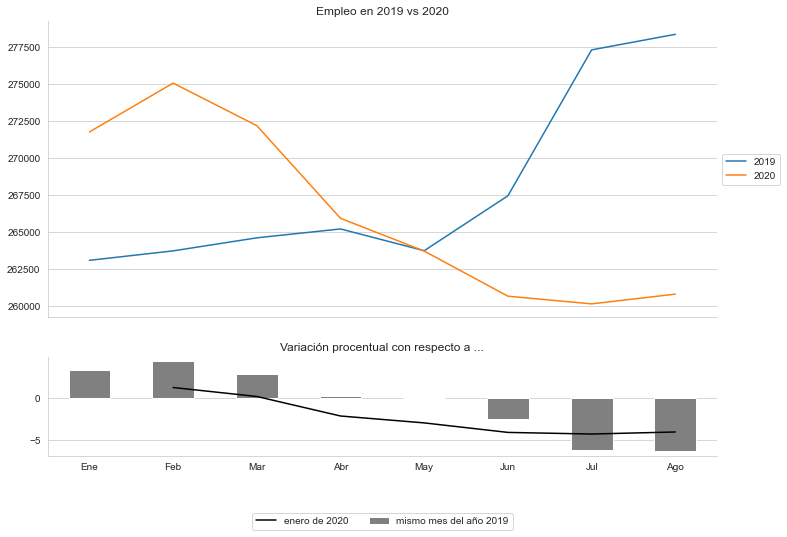

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
# Pequeñas empresas
# Gráfica Mes a mes
s_total_m_m.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020', ax=ax1)
ax1.xaxis.grid(False)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(ax=ax1)
# Gráfica variación procentual mes a mes
s_total_m_m_change.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax2, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_total_change_acum.loc[municipio].plot(ax=ax2, label='enero de 2020', kind='line', color='k')
ax2.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.80))
ax2.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax2.xaxis.grid(False)
sns.despine(ax=ax2)

# Empleo por sexo

In [8]:
file_imss_by_sexo = f'{dir_imss}/datamexico_asegurados_imss_x_sexo_202008.json'
if not os.path.exists(file_imss_by_sexo):
    url_imss_by_sexo = 'https://dev-api.datamexico.org/tesseract/data.jsonrecords?cube=imss&drilldowns=Municipality%2CMonth%2CSex&measures=Insured+Employment&parents=false&sparse=false'
    data = requests.get(url_imss_by_sexo).json()
    with open(file_imss_by_sexo, 'w', encoding='utf8') as imssfile:
        json.dump(data, imssfile)
else:
    with open(file_imss_by_sexo, 'r', encoding='utf8') as imssfile:
        data = json.load(imssfile)   

In [9]:
df_sexo = pd.DataFrame(data['data'])\
    .rename(columns={'Municipality ID': 'cve_mun', 'Insured Employment': 'asegurados'})\

df_sexo['year'] = df_sexo['Month'].str[:4].astype(int)
df_sexo['mes'] = df_sexo['Month'].str[5:].astype(int)
df_sexo['sexo'] = df_sexo['Sex ID'].map({1: 'Hombres', 2: 'Mujeres'})
df_sexo.set_index(['cve_mun', 'year', 'mes', 'sexo'], inplace=True)
df_sexo.to_csv('datos/semaforo/asegurados_x_sexo_202008.csv')
df_sexo.head()

asegurados    Month  Month ID    Municipality  \
cve_mun year mes sexo                                                     
1001    2019 1   Hombres      168492  2019-01    201901  Aguascalientes   
                 Mujeres       94582  2019-01    201901  Aguascalientes   
             2   Hombres      168421  2019-02    201902  Aguascalientes   
                 Mujeres       95292  2019-02    201902  Aguascalientes   
             3   Hombres      168559  2019-03    201903  Aguascalientes   

                             Sex  Sex ID  
cve_mun year mes sexo                     
1001    2019 1   Hombres    Male       1  
                 Mujeres  Female       2  
             2   Hombres    Male       1  
                 Mujeres  Female       2  
             3   Hombres    Male       1

In [10]:
empleo_sexo_m_m = df_sexo.query('year==[2019, 2020]')['asegurados'].unstack(['sexo', 'year'])
s_sexo_m_m_H = empleo_sexo_m_m['Hombres'].loc[idx[:, MES_INI:MES_FIN],]
s_sexo_m_m_M = empleo_sexo_m_m['Mujeres'].loc[idx[:, MES_INI:MES_FIN],]
s_sexo_m_m_change_M = s_sexo_m_m_M.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_sexo_m_m_change_H = s_sexo_m_m_H.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_sexo_change_acum_M =  s_sexo_m_m_M[2020].groupby('cve_mun').transform(lambda x: x.pct_change().replace({float('inf'): 1}).add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')
s_sexo_change_acum_H =  s_sexo_m_m_H[2020].groupby('cve_mun').transform(lambda x: x.pct_change().replace({float('inf'): 1}).add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')

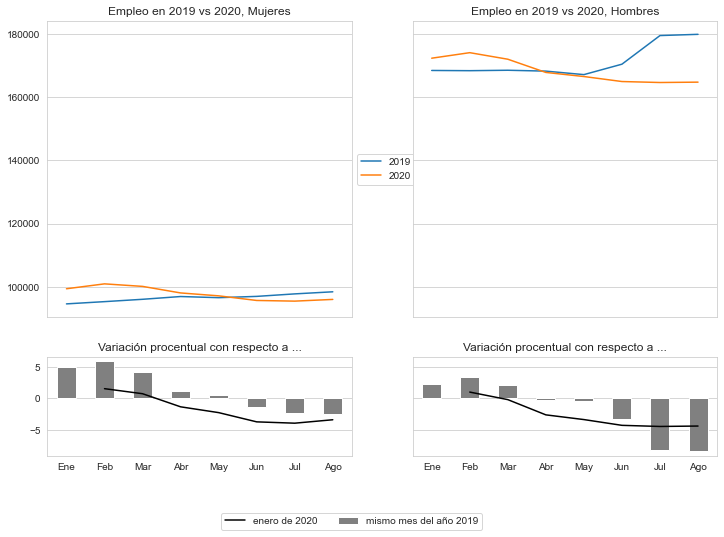

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
# Mujeres
# Gráfica Mes a mes
s_sexo_m_m_M.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020, Mujeres', ax=ax1)
ax1.xaxis.grid(False)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Gráfica variación procentual mes a mes
s_sexo_m_m_change_M.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax3, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_sexo_change_acum_M.loc[municipio].plot(ax=ax3, label='enero de 2020', kind='line', color='k')
ax3.legend(ncol=2, loc='lower center', bbox_to_anchor=(1, -0.80))
ax3.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax3.xaxis.grid(False)

# Hombres
# Gráfica Mes a mes
s_sexo_m_m_H.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020, Hombres', ax=ax2, legend=False)
ax2.xaxis.grid(False)
# Gráfica variación procentual mes a mes
s_sexo_m_m_change_H.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax4, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_sexo_change_acum_H.loc[municipio].plot(ax=ax4, label='enero de 2020', kind='line', color='k')
ax4.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax4.xaxis.grid(False)

# Empleo Jóvenes y adultos mayores

In [12]:
file_imss_by_edad = f'{dir_imss}/datamexico_asegurados_imss_x_edad_202008.json'
if not os.path.exists(file_imss_by_edad):
    url_imss_by_edad = 'https://dev-api.datamexico.org/tesseract/data.jsonrecords?cube=imss&drilldowns=Municipality%2CMonth%2CAge+Range&measures=Insured+Employment&parents=false&sparse=false'
    data = requests.get(url_imss_by_edad).json()
    with open(file_imss_by_edad, 'w', encoding='utf8') as imssfile:
        json.dump(data, imssfile)
else:
    with open(file_imss_by_edad, 'r', encoding='utf8') as imssfile:
        data = json.load(imssfile)   

In [13]:
df_edad = pd.DataFrame(data['data'])\
    .rename(columns={'Municipality ID': 'cve_mun', 'Insured Employment': 'asegurados'})\

df_edad['year'] = df_edad['Month'].str[:4].astype(int)
df_edad['mes'] = df_edad['Month'].str[5:].astype(int)
df_edad['categoria_edad'] = df_edad['Age Range ID'].pipe(pd.cut, bins=[0, 3, 9, 14], labels=['Jóvenes', 'Adultos', 'Mayores'])
df_edad.head()

,Age Range,Age Range ID,asegurados,Month,Month ID,Municipality,cve_mun,year,mes,categoria_edad
0,Less than 15 years old,1,11,2019-01,201901,Aguascalientes,1001,2019,1,Jóvenes
1,15 to 20 years,2,8850,2019-01,201901,Aguascalientes,1001,2019,1,Jóvenes
2,20 to 25 years,3,35401,2019-01,201901,Aguascalientes,1001,2019,1,Jóvenes
3,25 to 30 years,4,45558,2019-01,201901,Aguascalientes,1001,2019,1,Adultos
4,30 to 35 years,5,38726,2019-01,201901,Aguascalientes,1001,2019,1,Adultos


In [14]:
empleo_edad_m_m = df_edad.query('year==[2019, 2020] & categoria_edad==["Jóvenes", "Mayores"]').groupby(['cve_mun', 'year', 'mes', 'categoria_edad'])['asegurados'].sum()\
    .unstack(['categoria_edad', 'year'])
empleo_edad_m_m.stack(['year', 'categoria_edad'])\
    .to_frame('asegurados').to_csv('datos/semaforo/asegurados_x_edad_202008.csv')
s_edad_m_m_J = empleo_edad_m_m['Jóvenes'].loc[idx[:, MES_INI:MES_FIN],]
s_edad_m_m_M = empleo_edad_m_m['Mayores'].loc[idx[:, MES_INI:MES_FIN],]
s_edad_m_m_change_M = s_edad_m_m_M.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_edad_m_m_change_J = s_edad_m_m_J.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_edad_change_acum_M =  s_edad_m_m_M[2020].groupby('cve_mun').transform(lambda x: x.pct_change().replace({float('inf'): 1}).add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')
s_edad_change_acum_J =  s_edad_m_m_J[2020].groupby('cve_mun').transform(lambda x: x.pct_change().replace({float('inf'): 1}).add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')

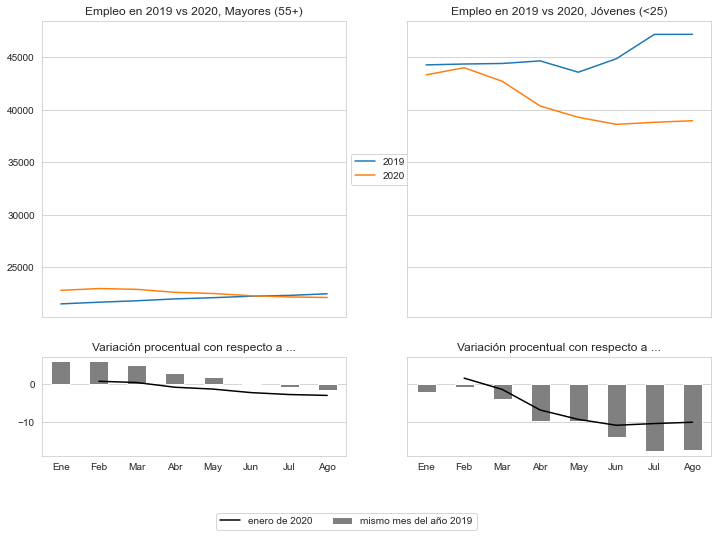

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
# Adultos Mayores
# Gráfica Mes a mes
s_edad_m_m_M.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020, Mayores (55+)', ax=ax1)
ax1.xaxis.grid(False)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Gráfica variación procentual mes a mes
s_edad_m_m_change_M.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax3, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_edad_change_acum_M.loc[municipio].plot(ax=ax3, label='enero de 2020', kind='line', color='k')
ax3.legend(ncol=2, loc='lower center', bbox_to_anchor=(1, -0.80))
ax3.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax3.xaxis.grid(False)

# Jóvenes
# Gráfica Mes a mes
s_edad_m_m_J.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020, Jóvenes (<25)', ax=ax2, legend=False)
ax2.xaxis.grid(False)
# Gráfica variación procentual mes a mes
s_edad_m_m_change_J.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax4, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_edad_change_acum_J.loc[municipio].plot(ax=ax4, label='enero de 2020', kind='line', color='k')
ax4.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax4.xaxis.grid(False)

# Empresas pequeñas

In [16]:
file_imss_by_pyme = f'{dir_imss}/datamexico_asegurados_imss_x_pyme_202008.json'
if not os.path.exists(file_imss_by_pyme):
    url_imss_by_pyme = 'https://dev-api.datamexico.org/tesseract/data.jsonrecords?cube=imss&drilldowns=Municipality%2CMonth%2CEmployer+Registration+Size&measures=Insured+Employment&parents=false&sparse=false'
    data = requests.get(url_imss_by_pyme).json()
    with open(file_imss_by_pyme, 'w', encoding='utf8') as imssfile:
        json.dump(data, imssfile)
else:
    with open(file_imss_by_pyme, 'r', encoding='utf8') as imssfile:
        data = json.load(imssfile)   

In [17]:
df_pyme = pd.DataFrame(data['data'])\
    .rename(columns={'Municipality ID': 'cve_mun', 'Insured Employment': 'asegurados'})\

df_pyme['year'] = df_pyme['Month'].str[:4].astype(int)
df_pyme['mes'] = df_pyme['Month'].str[5:].astype(int)
df_pyme['pequena'] = df_pyme['Employer Registration Size ID'].isin([1, 2, 3])
df_pyme.head()

,Employer Registration Size,Employer Registration Size ID,asegurados,Month,Month ID,Municipality,cve_mun,year,mes,pequena
0,Does not Apply,0,1185,2019-01,201901,Aguascalientes,1001,2019,1,False
1,1 Insured,1,3531,2019-01,201901,Aguascalientes,1001,2019,1,True
2,Between 2 and 5,2,16137,2019-01,201901,Aguascalientes,1001,2019,1,True
3,Between 6 and 50,3,58925,2019-01,201901,Aguascalientes,1001,2019,1,True
4,Between 51 and 250,4,56151,2019-01,201901,Aguascalientes,1001,2019,1,False


In [18]:
s_pyme_m_m = df_pyme.query('year==[2019, 2020] & pequena').groupby(['cve_mun', 'year', 'mes'])['asegurados'].sum()\
    .unstack('year').loc[idx[:, MES_INI:MES_FIN],]
s_pyme_m_m.stack().to_frame('asegurados').to_csv('datos/semaforo/asegurados_pyme_202008.csv')
s_pyme_m_m.head()

year            2019     2020
cve_mun mes                  
1001    1    78593.0  79396.0
        2    79341.0  79707.0
        3    79713.0  79596.0
        4    79798.0  78168.0
        5    78980.0  77789.0

In [19]:
s_pyme_m_m_change = s_pyme_m_m.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_pyme_change_acum =  s_pyme_m_m[2020].groupby('cve_mun').transform(lambda x: x.pct_change().add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')

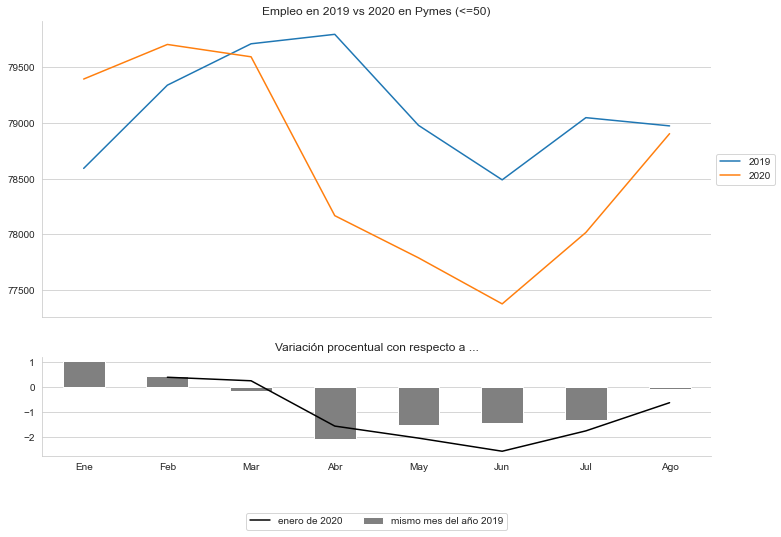

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
# Pequeñas empresas
# Gráfica Mes a mes
s_pyme_m_m.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020 en Pymes (<=50)', ax=ax1)
ax1.xaxis.grid(False)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(ax=ax1)
# Gráfica variación procentual mes a mes
s_pyme_m_m_change.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax2, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_pyme_change_acum.loc[municipio].plot(ax=ax2, label='enero de 2020', kind='line', color='k')
ax2.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.80))
ax2.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax2.xaxis.grid(False)
sns.despine(ax=ax2)

# Empleo por rango salarial

In [21]:
file_imss_by_uma = f'{dir_imss}/datamexico_asegurados_imss_x_uma_202008.json'
if not os.path.exists(file_imss_by_uma):
    url_imss_by_uma = 'https://dev-api.datamexico.org/tesseract/data.jsonrecords?cube=imss&drilldowns=Municipality%2CMonth%2CUMA+Range&measures=Insured+Employment&parents=false&sparse=false'
    data = requests.get(url_imss_by_uma).json()
    with open(file_imss_by_uma, 'w', encoding='utf8') as imssfile:
        json.dump(data, imssfile)
else:
    with open(file_imss_by_uma, 'r', encoding='utf8') as imssfile:
        data = json.load(imssfile)   

In [22]:
df_uma = pd.DataFrame(data['data'])\
    .rename(columns={'Municipality ID': 'cve_mun', 'Insured Employment': 'asegurados'})\

df_uma['year'] = df_uma['Month'].str[:4].astype(int)
df_uma['mes'] = df_uma['Month'].str[5:].astype(int)
df_uma['uma6'] = df_uma['UMA Range ID'].isin([1, 2, 3, 4, 5 , 6])
df_uma.head()

,asegurados,Month,Month ID,Municipality,cve_mun,UMA Range,UMA Range ID,year,mes,uma6
0,1232,2019-01,201901,Aguascalientes,1001,Does not apply,0,2019,1,False
1,541,2019-01,201901,Aguascalientes,1001,Up to 1 time the UMA,1,2019,1,True
2,87560,2019-01,201901,Aguascalientes,1001,Greater than 1 and up to 2 times the UMA,2,2019,1,True
3,46816,2019-01,201901,Aguascalientes,1001,Greater than 2 and up to 3 times the UMA,3,2019,1,True
4,29513,2019-01,201901,Aguascalientes,1001,Greater than 3 and up to 4 times the UMA,4,2019,1,True


In [23]:
s_uma_m_m = df_uma.query('year==[2019, 2020] & uma6').groupby(['cve_mun', 'year', 'mes'])['asegurados'].sum()\
    .unstack('year').loc[idx[:, MES_INI:MES_FIN],]
s_uma_m_m.stack().to_frame('asegurados').to_csv('datos/semaforo/asegurados_uma50_202008.csv')
s_uma_m_m.head()

year             2019      2020
cve_mun mes                    
1001    1    202579.0  201953.0
        2    206440.0  206487.0
        3    209190.0  205621.0
        4    209260.0  199146.0
        5    206848.0  198382.0

In [24]:
s_uma_m_m_change = s_uma_m_m.pipe(lambda df: df[2020].div(df[2019]).subtract(1).mul(100)).dropna().rename(dicc_meses, level='mes')
s_uma_change_acum =  s_uma_m_m[2020].groupby('cve_mun').transform(lambda x: x.pct_change().add(1).cumprod().subtract(1).mul(100)).rename(dicc_meses, level='mes')

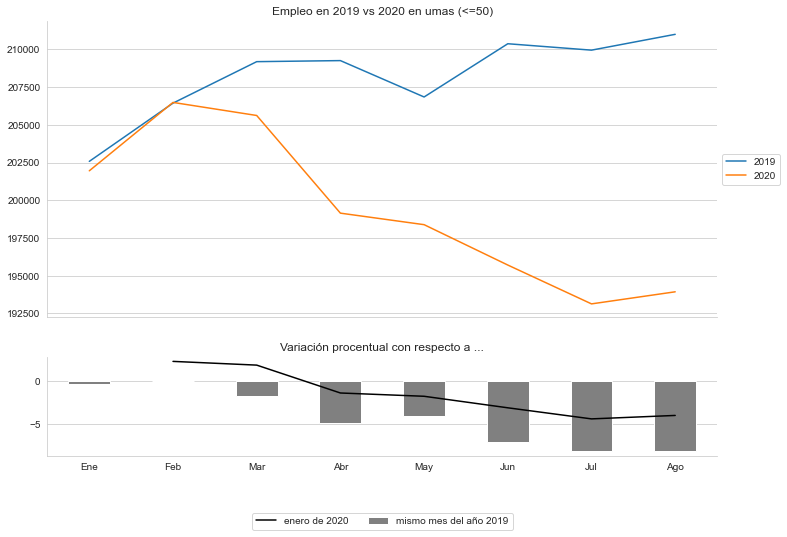

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
# Pequeñas empresas
# Gráfica Mes a mes
s_uma_m_m.rename(dicc_meses, level='mes').loc[municipio].plot(title='Empleo en 2019 vs 2020 en umas (<=50)', ax=ax1)
ax1.xaxis.grid(False)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(ax=ax1)
# Gráfica variación procentual mes a mes
s_uma_m_m_change.loc[municipio].plot.bar(title='Variación procentual con respecto a ...', ax=ax2, label='mismo mes del año 2019', color=COLOR_BARRAS_MM)
# Gráfica variación procentual acumulado
s_uma_change_acum.loc[municipio].plot(ax=ax2, label='enero de 2020', kind='line', color='k')
ax2.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.80))
ax2.set(xlim=(MES_INI-1.5, MES_FIN-0.5), xlabel='')
ax2.xaxis.grid(False)
sns.despine(ax=ax2)

# Datos Semaforo

In [26]:
dicc_meses[MES_FIN]

'Ago'

In [36]:
datos_semaforo = pd.concat([s_total_change_acum.to_frame('total'),
           s_sexo_change_acum_M.to_frame('mujeres'),
           s_edad_change_acum_J.to_frame('jovenes'),
           s_edad_change_acum_M.to_frame('mayores'),
           s_uma_change_acum.to_frame('uma'),
           s_pyme_change_acum.to_frame('pyme'),          
          ], axis=1).rename({v:k for k,v in dicc_meses.items()})\
        .sort_index()

#datos_semaforo.to_pickle('datos/crec_acum_semaforo_202008.pkl')
datos_semaforo_agos = datos_semaforo.xs(MES_FIN, axis=0, level='mes')
datos_semaforo_agos.to_csv('datos/semaforo/crec_acum_semaforo_202008.csv')
datos_semaforo.to_csv('datos/semaforo/crec_acum_semaforo_202008_meses.csv')
datos_semaforo.head()

total   mujeres   jovenes   mayores       uma      pyme
cve_mun mes                                                            
1001    1         NaN       NaN       NaN       NaN       NaN       NaN
        2    1.213997  1.558789  1.574621  0.745287  2.245077  0.391707
        3    0.156395  0.753733 -1.401459  0.412100  1.816264  0.251902
        4   -2.147218 -1.334380 -6.843369 -0.832968 -1.389927 -1.546677
        5   -2.961578 -2.259188 -9.318434 -1.319597 -1.768233 -2.024031

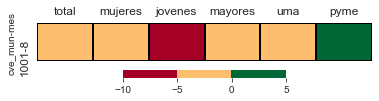

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
boundaries = [-10, -5, 0, 5]
cmap_total = cm.get_cmap('RdYlGn', len(boundaries))
norm = colors.BoundaryNorm(boundaries, cmap_total.N, clip=True)
ticks = np.linspace(min(boundaries), max(boundaries), len(boundaries)+1)
ax = sns.heatmap(datos_semaforo.loc[idx[1001, [8]],], linecolor='k', linewidths=1,
                 cmap=cmap_total, cbar_kws={'ticks': boundaries, 'orientation': 'horizontal'},
                 norm=norm)
ax.figure.set_size_inches(6, 1)
ax.tick_params(axis='both', which='major', labelsize=12, 
               labelbottom = False, bottom=False, top = False, labeltop=True)


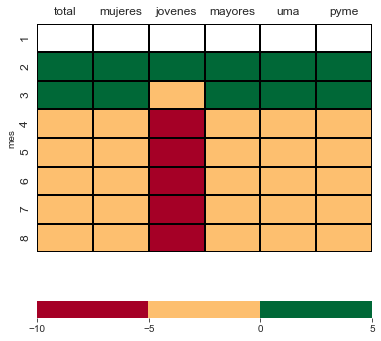

In [100]:
ax = sns.heatmap(datos_semaforo.loc[idx[1001], ], linecolor='k', linewidths=1, 
            cmap=cmap_total, cbar_kws={'ticks': boundaries, 'orientation': 'horizontal'},
                 norm=norm)
ax.figure.set_size_inches(6, 6)
ax.tick_params(axis='both', which='major', labelsize=12, 
               labelbottom = False, bottom=False, top = False, labeltop=True)

In [37]:
datos_semaforo_agos

,total,mujeres,jovenes,mayores,uma,pyme
count,1931.000000,1802.000000,1708.000000,1729.000000,1927.000000,1926.000000
mean,20.744815,6.633661,10.949836,5.111193,20.777660,24.286077
std,168.995955,55.000730,122.200561,59.005858,164.510458,172.200242
min,-100.000000,-100.000000,-100.000000,-92.537313,-95.121951,-98.181818
25%,-8.469574,-7.142857,-19.361413,-7.608696,-8.693010,-6.345995
50%,-0.148112,0.000000,-4.571578,0.000000,0.000000,0.000000
75%,7.399886,6.272645,7.236649,7.246377,9.084218,9.592491
max,4000.000000,1001.886792,3300.000000,1826.666667,4000.000000,4000.000000


In [29]:
datos_semaforo

,total,mujeres,jovenes,mayores,uma,pyme
cve_mun,,,,,,
1001,-4.031691,-3.395323,-1.007573e+01,-2.989917e+00,-3.972211,-6.184191e-01
1002,0.713649,6.792453,9.375000e+00,7.653061e+00,5.263158,8.742004e+00
1003,-2.774032,2.847806,-5.746141e+00,3.908046e+00,-2.959566,-5.720824e+00
1004,-2.111801,3.936039,-1.322581e+01,4.794521e+00,-1.955671,-1.454545e+01
1006,2.482495,4.653802,4.600484e+00,2.666667e+00,4.388610,7.493703e+00
1007,4.603960,7.980050,8.297872e+00,7.002188e+00,3.857479,1.452081e+00
1008,-3.146853,-2.857143,-3.461538e+01,1.000000e+01,-3.321033,-1.666667e+01
1009,-4.901438,-6.303725,-1.134021e+01,2.608696e+00,-4.372760,2.220446e-14
1010,-39.120580,-18.544601,-5.221053e+01,-5.882353e+00,-23.016905,-2.429022e+01
